# Notes

This architecture was described in "Deep learning with convolutional neural networks for brain mapping and decoding of movement-related information from the human EEG", by R. T. Schmirrmester et al, 2018. In this notebook we conduct experimetns showing the importance of using batchnorm/dropout layers, and dependacy between accuracy and the number of timestamps in a sample.

# Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [4]:
cd ..

/Users/sriramsonti/Desktop/project_C247


# Load the data

### Read the files

In [5]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

### Shape of data

In [6]:
print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [7]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### Augmented dataset

In [8]:
def sliding_window(X_arr, y_arr, time_window=100, time_step=1, time_stride=1):
    temp_x = np.moveaxis(X_arr, 2, 0)
    temp_x = temp_x.astype(np.float32)
    buff = []
    
    num_slices = (len(temp_x)-time_window*time_step) // time_stride + 1
    
    # get time slices for data
    for i in range(num_slices):
        buff.append(temp_x[i*time_stride:i*time_stride + time_window*time_step:time_step])
        buff[i] = np.moveaxis(buff[i], 0, 2)
        # uncomment this if additional dimension is needed
        # buff[i] = buff[i].reshape(1, buff[i].shape[0], buff[i].shape[1], buff[i].shape[2])
        
    temp_x = np.concatenate(buff)
        
    # get time slice for labels
    temp_y = np.ones((X_arr.shape[0],num_slices))
    
    for i in range(len(y_arr)):
        temp_y[i] = temp_y[i] * y_arr[i]
        
    temp_y = temp_y.reshape((-1))
    
    return temp_x, temp_y

# Experiment 1: naive implementation of deep model

In this experiment, we show that naive implementation of deep convolutional model can not return good results because of overfit.

### Construct model

In [9]:
# input
deep_input = layers.Input(shape=(22, 1000))



# ================================== CONV1 ================================== #

# conv accross time domain
r1 = layers.Reshape((22, 1000, 1))(deep_input)
c1 = layers.Conv2D(25, (1, 10), strides=(1, 1), activation="elu")(r1)
t1 = tf.keras.layers.Permute((2, 3, 1))(c1)

# conv accross channels
r2 = layers.Reshape((991, 25*22, 1))(t1)
c2 = layers.Conv2D(25, (1, 25*22), strides=(1, 1), activation="elu")(r2)

# max pool across time domain
r3 = layers.Reshape((991, 25, 1))(c2)
maxpool3 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r3)

# =========================================================================== #



# ================================= CONV2-4 ================================= #

c4 = layers.Conv2D(50, (10, 25), strides=(1, 1), activation="elu")(maxpool3)
r4 = layers.Reshape((321, 50, 1))(c4)
maxpool4 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r4)

c5 = layers.Conv2D(100, (10, 50), strides=(1, 1), activation="elu")(maxpool4)
r5 = layers.Reshape((98, 100, 1))(c5)
maxpool5 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r5)

c6 = layers.Conv2D(200, (10, 100), strides=(1, 1), activation="elu")(maxpool5)
r6 = layers.Reshape((23, 200, 1))(c6)
maxpool6 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r6)

# =========================================================================== #

f7 = layers.Flatten()(r6)

# output
deep_output = layers.Dense(4, activation="softmax")(f7)

In [10]:
deep_model = keras.Model(inputs = deep_input, outputs = deep_output, name="deep_model")
deep_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [11]:
deep_model.summary()

Model: "deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 991, 25)       275       
_________________________________________________________________
permute (Permute)            (None, 991, 25, 22)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 991, 550, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 991, 1, 25)        13775     
_________________________________________________________________
reshape_2 (Reshape)          (None, 991, 25, 1)        0

### Make checkpoints

In [12]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/deep_model_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

### Train model on single person

In [14]:
person_num = 0
indices_train_valid = np.where(person_train_valid == person_num)[0]
indices_test = np.where(person_test == person_num)[0]

single_person_X_train_valid = X_train_valid[indices_train_valid]
single_person_y_train_valid = y_train_valid[indices_train_valid]

perm = np.random.permutation(single_person_X_train_valid.shape[0])
num_train = int(0.8 * single_person_X_train_valid.shape[0])
num_valid = single_person_X_train_valid.shape[0] - num_train
single_person_X_train =  single_person_X_train_valid[perm[0:num_train]]
single_person_y_train =  single_person_y_train_valid[perm[0:num_train]]
single_person_X_valid = single_person_X_train_valid[perm[num_train: ]]
single_person_y_valid = single_person_y_train_valid[perm[num_train: ]]

single_person_X_test = X_test[indices_test]
single_person_y_test = y_test[indices_test]


print("Training data shape for 1 person: {}".format(single_person_X_train.shape))
print("Training label shape for 1 person: {}".format(single_person_y_train.shape))
print("Validation data shape for 1 person: {}".format(single_person_X_valid.shape))
print("Validation label shape for 1 person: {}".format(single_person_y_valid.shape))
print("Test data shape for 1 person: {}".format(single_person_X_test.shape))
print("Test label shape for 1 person: {}".format(single_person_y_test.shape))

Training data shape for 1 person: (189, 22, 1000)
Training label shape for 1 person: (189,)
Validation data shape for 1 person: (48, 22, 1000)
Validation label shape for 1 person: (48,)
Test data shape for 1 person: (50, 22, 1000)
Test label shape for 1 person: (50,)


In [16]:
deep_model_single = keras.Model(inputs = deep_input, outputs = deep_output, name="deep_model")
deep_model_single.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
deep_model_single.fit(single_person_X_train, single_person_y_train,
                                            validation_data = (single_person_X_valid, single_person_y_valid),
                                            epochs = 30)

Train on 189 samples, validate on 48 samples
Epoch 1/30
189/189 [==============================] - 14s 74ms/sample - loss: 1.3916 - acc: 0.2011 - val_loss: 1.3866 - val_acc: 0.2292
Epoch 2/30
189/189 [==============================] - 11s 59ms/sample - loss: 1.3955 - acc: 0.2751 - val_loss: 1.3862 - val_acc: 0.2500
Epoch 3/30
189/189 [==============================] - 11s 59ms/sample - loss: 1.3864 - acc: 0.2751 - val_loss: 1.3866 - val_acc: 0.2083
Epoch 4/30
189/189 [==============================] - 11s 57ms/sample - loss: 1.3863 - acc: 0.2593 - val_loss: 1.3865 - val_acc: 0.2083
Epoch 5/30
189/189 [==============================] - 11s 56ms/sample - loss: 1.3862 - acc: 0.2593 - val_loss: 1.3861 - val_acc: 0.2083
Epoch 6/30
189/189 [==============================] - 10s 55ms/sample - loss: 1.3884 - acc: 0.2751 - val_loss: 1.3744 - val_acc: 0.2917
Epoch 7/30
189/189 [==============================] - 10s 53ms/sample - loss: 1.3728 - acc: 0.3175 - val_loss: 1.3721 - val_acc: 0.2500
Epo

In [17]:
deep_model_single.evaluate(single_person_X_test, single_person_y_test)

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[14.465117111206055, 0.5]

In [19]:
deep_model_single.evaluate(X_test, y_test)

443/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[15.780269883287142, 0.255079]

### Train model

In [19]:
deep_model_loss_hist = deep_model.fit(X_train, y_train,
                                      validation_data = (X_valid, y_valid),
                                      epochs = 30,
                                      callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.3757 - acc: 0.3035
Epoch 00001: val_loss did not improve from 1.32418
1692/1692 [==============================] - 14s 8ms/sample - loss: 1.3776 - acc: 0.3026 - val_loss: 1.3581 - val_acc: 0.3641
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2591 - acc: 0.4111
Epoch 00002: val_loss improved from 1.32418 to 1.26177, saving model to ./model_checkpoints/deep_model_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/deep_model_1000\assets
1692/1692 [==============================] - 15s 9ms/sample - loss: 1.2600 - acc: 0.4119 - val_loss: 1.2618 - val_acc: 0.4232
Epoch 3/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2439 - acc: 0.4411
Epoch 00003: val_loss improved from 1.26177 to 1.23481, saving model to ./model_checkpoints/deep_model_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/deep_model_1000\assets

### Make plots

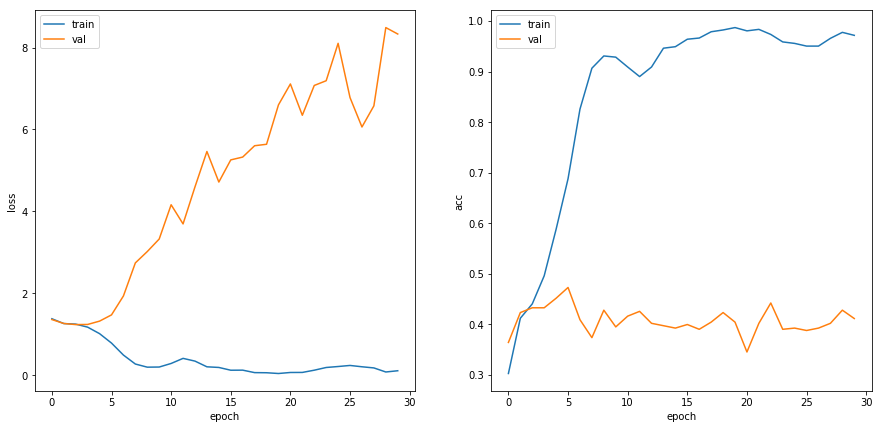

In [21]:
hist = deep_model_loss_hist### Train model.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 2: deep model with augmentations

In this experiment we show that deep convolutional model can achieve good results if dropout and batchnorm are used. 

### Construct model

In [32]:
def construct_augmented_deep_model(TIME_WINDOW):
    # input
    deep_aug_input = layers.Input(shape=(22, TIME_WINDOW))


    # ================================== CONV1 ================================== #

    # conv accross time domain
    r1 = layers.Reshape((22, TIME_WINDOW, 1))(deep_aug_input)
    c1 = layers.Conv2D(25, (1, 10), strides=(1, 1))(r1)
    new_size = TIME_WINDOW - 10 + 1
    t1 = tf.keras.layers.Permute((2, 3, 1))(c1)

    # # conv accross channels
    r2 = layers.Reshape((new_size, 25*22, 1))(t1)
    c2 = layers.Conv2D(25, (1, 25*22), strides=(1, 1))(r2)
    bn2 = layers.BatchNormalization(axis=1)(c2)                 # do I use the right filter?
    a2 = layers.Activation("elu")(bn2)


    # max pool across time domain
    r3 = layers.Reshape((new_size, 25, 1))(a2)
    maxpool3 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r3)
    new_size = (new_size - 3)//3 + 1
    
    # # =========================================================================== #



    # # ================================= CONV2-4 ================================= #

    c4 = layers.Conv2D(50, (10, 25), strides=(1, 1))(maxpool3)
    new_size = new_size - 10 + 1
    bn4 = layers.BatchNormalization(axis=1)(c4)
    a4 = layers.Activation("elu")(bn4)
    do4 = layers.Dropout(0.5)(a4)
    r4 = layers.Reshape((new_size, 50, 1))(do4)
    maxpool4 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r4)
    new_size = (new_size - 3)//3 + 1
    

    c5 = layers.Conv2D(100, (10, 50), strides=(1, 1))(maxpool4)
    new_size = new_size - 10 + 1
    bn5 = layers.BatchNormalization(axis=1)(c5)
    a5 = layers.Activation("elu")(bn5)
    do5 = layers.Dropout(0.5)(a5)
    r5 = layers.Reshape((new_size, 100, 1))(do5)
    maxpool5 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r5)
    new_size = (new_size - 3)//3 + 1
    

    c6 = layers.Conv2D(200, (10, 100), strides=(1, 1))(maxpool5)
    new_size = new_size - 10 + 1
    bn6 = layers.BatchNormalization(axis=1)(c6)
    a6 = layers.Activation("elu")(bn6)
    do6 = layers.Dropout(0.5)(a6)
    r6 = layers.Reshape((new_size, 200, 1))(do6)
    maxpool6 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(r6)

    # # =========================================================================== #

    f7 = layers.Flatten()(do6)

    # output
    deep_aug_output = layers.Dense(4, activation="softmax")(f7)
    
    return keras.Model(inputs = deep_aug_input, outputs = deep_aug_output, name="deep_aug_model")

In [27]:
deep_aug_model_1000 = construct_augmented_deep_model(1000)
deep_aug_model_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [28]:
deep_aug_model_1000.summary()

Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 991, 25)       275       
_________________________________________________________________
permute_4 (Permute)          (None, 991, 25, 22)       0         
_________________________________________________________________
reshape_25 (Reshape)         (None, 991, 550, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 991, 1, 25)        13775     
_________________________________________________________________
batch_normalization_4 (Batch (None, 991, 1, 25)     

### Make checkpoints

In [24]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/augmented_deep_model_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

### Train model

In [29]:
deep_aug_model_1000_loss_hist = deep_aug_model_1000.fit(X_train, y_train,
                                                        validation_data = (X_valid, y_valid),
                                                        epochs = 60,
                                                        callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/60
1664/1692 [============================>.] - ETA: 0s - loss: 2.0531 - acc: 0.2488
Epoch 00001: val_loss did not improve from 1.09119
1692/1692 [==============================] - 15s 9ms/sample - loss: 2.0498 - acc: 0.2476 - val_loss: 2.2321 - val_acc: 0.2695
Epoch 2/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.5540 - acc: 0.2698
Epoch 00002: val_loss did not improve from 1.09119
1692/1692 [==============================] - 14s 8ms/sample - loss: 1.5516 - acc: 0.2701 - val_loss: 1.4844 - val_acc: 0.2742
Epoch 3/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.4981 - acc: 0.2855
Epoch 00003: val_loss did not improve from 1.09119
1692/1692 [==============================] - 14s 8ms/sample - loss: 1.4991 - acc: 0.2849 - val_loss: 1.4466 - val_acc: 0.2955
Epoch 4/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.4622 - acc: 0.3161
Epoch 00004: val_loss did not improve from 1.09119

Epoch 59/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.2824 - acc: 0.8960
Epoch 00059: val_loss did not improve from 1.03585
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.2806 - acc: 0.8972 - val_loss: 1.2719 - val_acc: 0.5863
Epoch 60/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.2622 - acc: 0.9050
Epoch 00060: val_loss did not improve from 1.03585
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.2601 - acc: 0.9060 - val_loss: 1.2812 - val_acc: 0.5957


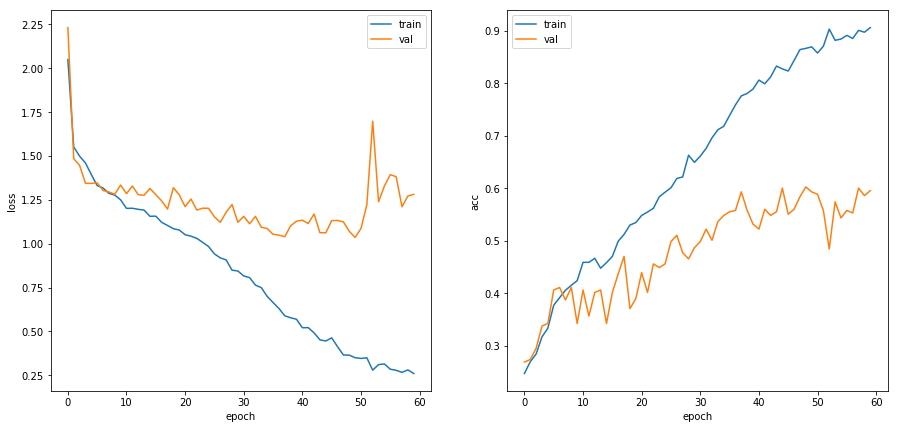

In [30]:
hist = deep_aug_model_1000_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 3: Augmented deep model - accuracy vs number of timestamps

### Train models

In [33]:
TIME_WINDOW = 900
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/augmented_deep_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


deep_aug_model_900 = construct_augmented_deep_model(TIME_WINDOW)
deep_aug_model_900.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

deep_aug_model_900.summary()

deep_aug_model_900.fit(X_train_slices, y_train_slices,
                       validation_data = (X_valid_slices, y_valid_slices),
                       epochs = 60,
                       callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 900)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 900)
Validation label shape with slice: (423,)
Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 22, 900)]         0         
_________________________________________________________________
reshape_36 (Reshape)         (None, 22, 900, 1)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 22, 891, 25)       275       
_________________________________________________________________
permute_6 (Permute)          (None, 891, 25, 22)       0         
_________________________________________________________________
reshape_37 (Reshape)         (None, 891, 550, 1)       0         
_________________________________________________________________
co

1664/1692 [============================>.] - ETA: 0s - loss: 0.5131 - acc: 0.8023
Epoch 00038: val_loss did not improve from 1.05046
1692/1692 [==============================] - 13s 8ms/sample - loss: 0.5154 - acc: 0.8014 - val_loss: 1.1181 - val_acc: 0.5626
Epoch 39/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.4662 - acc: 0.8257
Epoch 00039: val_loss did not improve from 1.05046
1692/1692 [==============================] - 13s 7ms/sample - loss: 0.4656 - acc: 0.8262 - val_loss: 1.0760 - val_acc: 0.5792
Epoch 40/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.4243 - acc: 0.8347
Epoch 00040: val_loss improved from 1.05046 to 1.04176, saving model to ./model_checkpoints/augmented_deep_model_900
INFO:tensorflow:Assets written to: ./model_checkpoints/augmented_deep_model_900\assets
1692/1692 [==============================] - 15s 9ms/sample - loss: 0.4210 - acc: 0.8369 - val_loss: 1.0418 - val_acc: 0.5981
Epoch 41/60
1664/1692 [=======================

In [36]:
TIME_WINDOW = 800
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/augmented_deep_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


deep_aug_model_800 = construct_augmented_deep_model(TIME_WINDOW)
deep_aug_model_800.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

deep_aug_model_800.summary()

deep_aug_model_800.fit(X_train_slices, y_train_slices,
                       validation_data = (X_valid_slices, y_valid_slices),
                       epochs = 60,
                       callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 800)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 800)
Validation label shape with slice: (423,)
Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 22, 800)]         0         
_________________________________________________________________
reshape_42 (Reshape)         (None, 22, 800, 1)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 22, 791, 25)       275       
_________________________________________________________________
permute_7 (Permute)          (None, 791, 25, 22)       0         
_________________________________________________________________
reshape_43 (Reshape)         (None, 791, 550, 1)       0         
_________________________________________________________________
co

Epoch 11/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.2358 - acc: 0.4423
Epoch 00011: val_loss did not improve from 1.27078
1692/1692 [==============================] - 11s 7ms/sample - loss: 1.2320 - acc: 0.4450 - val_loss: 1.2886 - val_acc: 0.3830
Epoch 12/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.2271 - acc: 0.4489
Epoch 00012: val_loss did not improve from 1.27078
1692/1692 [==============================] - 11s 7ms/sample - loss: 1.2295 - acc: 0.4456 - val_loss: 1.3083 - val_acc: 0.3830
Epoch 13/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.1999 - acc: 0.4561
Epoch 00013: val_loss did not improve from 1.27078
1692/1692 [==============================] - 11s 7ms/sample - loss: 1.2022 - acc: 0.4551 - val_loss: 1.3434 - val_acc: 0.3522
Epoch 14/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.1779 - acc: 0.4657
Epoch 00014: val_loss improved from 1.27078 to 1.26032, saving model to ./model_checkpoints/a

Epoch 38/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5815 - acc: 0.7752
Epoch 00038: val_loss did not improve from 1.09754
1692/1692 [==============================] - 11s 7ms/sample - loss: 0.5824 - acc: 0.7742 - val_loss: 1.2311 - val_acc: 0.5508
Epoch 39/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.6060 - acc: 0.7698
Epoch 00039: val_loss did not improve from 1.09754
1692/1692 [==============================] - 11s 7ms/sample - loss: 0.6056 - acc: 0.7689 - val_loss: 1.1718 - val_acc: 0.5626
Epoch 40/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5043 - acc: 0.8053
Epoch 00040: val_loss did not improve from 1.09754
1692/1692 [==============================] - 11s 7ms/sample - loss: 0.5124 - acc: 0.8020 - val_loss: 1.2479 - val_acc: 0.5697
Epoch 41/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5031 - acc: 0.8023
Epoch 00041: val_loss did not improve from 1.09754
1692/1692 [==============================]

In [37]:
TIME_WINDOW = 700
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/augmented_deep_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


deep_aug_model_700 = construct_augmented_deep_model(TIME_WINDOW)
deep_aug_model_700.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

deep_aug_model_700.summary()

deep_aug_model_700.fit(X_train_slices, y_train_slices,
                       validation_data = (X_valid_slices, y_valid_slices),
                       epochs = 60,
                       callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 700)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 700)
Validation label shape with slice: (423,)
Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 22, 700)]         0         
_________________________________________________________________
reshape_48 (Reshape)         (None, 22, 700, 1)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 22, 691, 25)       275       
_________________________________________________________________
permute_8 (Permute)          (None, 691, 25, 22)       0         
_________________________________________________________________
reshape_49 (Reshape)         (None, 691, 550, 1)       0         
_________________________________________________________________
co

Epoch 38/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.6128 - acc: 0.7602
Epoch 00038: val_loss did not improve from 1.04448
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.6185 - acc: 0.7571 - val_loss: 1.1109 - val_acc: 0.5508
Epoch 39/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5904 - acc: 0.7734
Epoch 00039: val_loss did not improve from 1.04448
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.5873 - acc: 0.7742 - val_loss: 1.1586 - val_acc: 0.5366
Epoch 40/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5344 - acc: 0.7975
Epoch 00040: val_loss did not improve from 1.04448
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.5348 - acc: 0.7973 - val_loss: 1.0581 - val_acc: 0.5839
Epoch 41/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5315 - acc: 0.7837- ETA: 4s - loss
Epoch 00041: val_loss did not improve from 1.04448
1692/1692 [===============

In [38]:
TIME_WINDOW = 600
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/augmented_deep_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


deep_aug_model_600 = construct_augmented_deep_model(TIME_WINDOW)
deep_aug_model_600.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

deep_aug_model_600.summary()

deep_aug_model_600.fit(X_train_slices, y_train_slices,
                       validation_data = (X_valid_slices, y_valid_slices),
                       epochs = 60,
                       callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 600)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 600)
Validation label shape with slice: (423,)
Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 22, 600)]         0         
_________________________________________________________________
reshape_54 (Reshape)         (None, 22, 600, 1)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 22, 591, 25)       275       
_________________________________________________________________
permute_9 (Permute)          (None, 591, 25, 22)       0         
_________________________________________________________________
reshape_55 (Reshape)         (None, 591, 550, 1)       0         
_________________________________________________________________
co

INFO:tensorflow:Assets written to: ./model_checkpoints/augmented_deep_model_600\assets
1692/1692 [==============================] - 11s 6ms/sample - loss: 1.1881 - acc: 0.4569 - val_loss: 1.2567 - val_acc: 0.4161
Epoch 13/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.1823 - acc: 0.4718
Epoch 00013: val_loss improved from 1.25668 to 1.24084, saving model to ./model_checkpoints/augmented_deep_model_600
INFO:tensorflow:Assets written to: ./model_checkpoints/augmented_deep_model_600\assets
1692/1692 [==============================] - 11s 6ms/sample - loss: 1.1824 - acc: 0.4710 - val_loss: 1.2408 - val_acc: 0.4184
Epoch 14/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.1660 - acc: 0.4802
Epoch 00014: val_loss did not improve from 1.24084
1692/1692 [==============================] - 9s 5ms/sample - loss: 1.1638 - acc: 0.4811 - val_loss: 1.3025 - val_acc: 0.3641
Epoch 15/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.1350 - acc: 0.4898

Epoch 37/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5218 - acc: 0.7915
Epoch 00037: val_loss did not improve from 0.94194
1692/1692 [==============================] - 9s 5ms/sample - loss: 0.5247 - acc: 0.7908 - val_loss: 0.9720 - val_acc: 0.6028
Epoch 38/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.5371 - acc: 0.7957
Epoch 00038: val_loss did not improve from 0.94194
1692/1692 [==============================] - 9s 5ms/sample - loss: 0.5381 - acc: 0.7955 - val_loss: 0.9791 - val_acc: 0.5863
Epoch 39/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.4645 - acc: 0.8299
Epoch 00039: val_loss did not improve from 0.94194
1692/1692 [==============================] - 9s 5ms/sample - loss: 0.4790 - acc: 0.8257 - val_loss: 1.0717 - val_acc: 0.5957
Epoch 40/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.4430 - acc: 0.8269
Epoch 00040: val_loss did not improve from 0.94194
1692/1692 [==============================] - 

In [39]:
TIME_WINDOW = 500
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/augmented_deep_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


deep_aug_model_500 = construct_augmented_deep_model(TIME_WINDOW)
deep_aug_model_500.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

deep_aug_model_500.summary()

deep_aug_model_500.fit(X_train_slices, y_train_slices,
                       validation_data = (X_valid_slices, y_valid_slices),
                       epochs = 60,
                       callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 500)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 500)
Validation label shape with slice: (423,)
Model: "deep_aug_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 22, 500)]         0         
_________________________________________________________________
reshape_60 (Reshape)         (None, 22, 500, 1)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 22, 491, 25)       275       
_________________________________________________________________
permute_10 (Permute)         (None, 491, 25, 22)       0         
_________________________________________________________________
reshape_61 (Reshape)         (None, 491, 550, 1)       0         
_________________________________________________________________
co

1692/1692 [==============================] - 9s 5ms/sample - loss: 1.1048 - acc: 0.5390 - val_loss: 1.1462 - val_acc: 0.5366
Epoch 11/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.0258 - acc: 0.5577
Epoch 00011: val_loss did not improve from 1.14620
1692/1692 [==============================] - 7s 4ms/sample - loss: 1.0258 - acc: 0.5556 - val_loss: 1.1882 - val_acc: 0.4988
Epoch 12/60
1664/1692 [============================>.] - ETA: 0s - loss: 1.0254 - acc: 0.5703
Epoch 00012: val_loss did not improve from 1.14620
1692/1692 [==============================] - 7s 4ms/sample - loss: 1.0206 - acc: 0.5745 - val_loss: 1.1722 - val_acc: 0.4965
Epoch 13/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.9790 - acc: 0.6094
Epoch 00013: val_loss improved from 1.14620 to 1.07920, saving model to ./model_checkpoints/augmented_deep_model_500
INFO:tensorflow:Assets written to: ./model_checkpoints/augmented_deep_model_500\assets
1692/1692 [==========================

Epoch 37/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.3870 - acc: 0.8546
Epoch 00037: val_loss did not improve from 0.92171
1692/1692 [==============================] - 7s 4ms/sample - loss: 0.3890 - acc: 0.8528 - val_loss: 0.9799 - val_acc: 0.6501
Epoch 38/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.3843 - acc: 0.8462
Epoch 00038: val_loss did not improve from 0.92171
1692/1692 [==============================] - 7s 4ms/sample - loss: 0.3830 - acc: 0.8463 - val_loss: 1.2012 - val_acc: 0.5839
Epoch 39/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.4513 - acc: 0.8359
Epoch 00039: val_loss did not improve from 0.92171
1692/1692 [==============================] - 7s 4ms/sample - loss: 0.4479 - acc: 0.8369 - val_loss: 1.1083 - val_acc: 0.5887
Epoch 40/60
1664/1692 [============================>.] - ETA: 0s - loss: 0.3450 - acc: 0.8660
Epoch 00040: val_loss did not improve from 0.92171
1692/1692 [==============================] - 

### Get accuracies

In [42]:
best_deep_aug_model_500 = keras.models.load_model('./model_checkpoints/augmented_deep_model_500')
best_deep_aug_model_600 = keras.models.load_model('./model_checkpoints/augmented_deep_model_600')
best_deep_aug_model_700 = keras.models.load_model('./model_checkpoints/augmented_deep_model_700')
best_deep_aug_model_800 = keras.models.load_model('./model_checkpoints/augmented_deep_model_800')
best_deep_aug_model_900 = keras.models.load_model('./model_checkpoints/augmented_deep_model_900')
best_deep_aug_model_1000 = keras.models.load_model('./model_checkpoints/augmented_deep_model_1000')

number_of_samples = [500, 600, 700, 800, 900, 1000]
accuracies = []



# ==================================== 500 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=500, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_deep_aug_model_500.evaluate(X_valid_slices, y_valid_slices)[1])



# ==================================== 600 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=600, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_deep_aug_model_600.evaluate(X_valid_slices, y_valid_slices)[1])



# ==================================== 700 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=700, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_deep_aug_model_700.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 800 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=800, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_deep_aug_model_800.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 900 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=900, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_deep_aug_model_900.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 1000 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=1000, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_deep_aug_model_1000.evaluate(X_valid_slices, y_valid_slices)[1])


423/423 [==============================] - 1s 3ms/sample - loss: 1.0358 - acc: 0.5934


# Plot the results

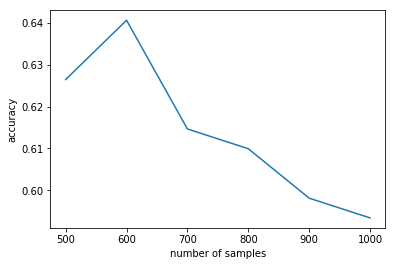

In [43]:
fig = plt.figure()
ax = plt.axes()

plt.xlabel('number of samples')
plt.ylabel('accuracy')
ax.plot(number_of_samples, accuracies);# Plot the results

# Results

In [44]:
X_test_slices, y_test_slices = sliding_window(X_test, 
                                              y_test, 
                                              time_window=600, 
                                              time_stride=TIME_STRIDE)

deep_model_results = best_deep_aug_model_600.evaluate(X_test_slices, y_test_slices)


print('Deep model test loss:', deep_model_results[0])
print('Deep model test acc:', deep_model_results[1])

443/443 [==============================] - 1s 1ms/sample - loss: 1.0110 - acc: 0.6140
Deep model test loss: 1.0109507561268172
Deep model test acc: 0.6139955
